# Chapter 3
Chapter 3 is about Convolutional Neural Networks (CNNs) and data augmentation.

**Idea Convolutions:** Convolutions are tools to learn spatial patterns and can recognise simple patterns like horizontal or vertical lines. When stacking convolutions, they begin to recognise more complex patterns by building on top of the recognized simpler patterns.

In this chapter we will first learn to build our own convolutions and in the end learn about data augmentation techniques.

In [15]:
import torchvision
from torchvision import transforms
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import torch 
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader
from idlmam import train_simple_network
from sklearn.metrics import accuracy_score

mnist_data_train = torchvision.datasets.MNIST(
    "./data", train=True, download=True, transform=transforms.ToTensor())
mnist_data_test = torchvision.datasets.MNIST(
    "./data", train=False, download=True, transform=transforms.ToTensor())

x_example, y_example = mnist_data_train[0]
type(x_example)  # returns PIL image without transform

torch.Tensor

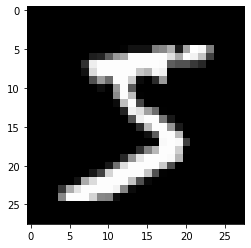

In [2]:
imshow(x_example[0,:], cmap="gray")

torch.Size([3, 28, 28])


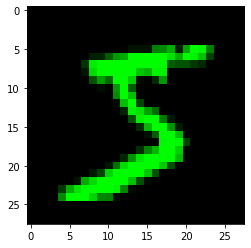

In [3]:
# stack the same image on each other to create an image with three channels
x_as_color = torch.stack([x_example[0,:],x_example[0,:],x_example[0,:]], dim=0)
print(x_as_color.shape)

# if we want to show the image, we need to permute the dimensions. (imshow needs W,H,C)
imshow(x_as_color.permute(1,2,0))

# still black and white since we stacked the same channels three times
# change the channels (zero out)
x_as_color[0,:] = 0
x_as_color[2,:] = 0
imshow(x_as_color.permute(1,2,0))

## Convolutions
Convolutions are functions which have two inputs, the input (image) and a filter(=kernel). The output is a new image. The goal of the convolution is to find certain patterns, it defines what kind of pattern to look for. Convolutions can be 1D, 2D, 3D, ... 
We will start with 1D Convolutions.

**1D Convolutions** A 1D Image just has the size (C, W) and no height, since it is 1D, hence the image only has Channels C and the Width W. We can now apply a filter of size (C,K) to the image. This filter must always match the number of channels, however, we can freely chosse the value K, which is the size fo the filter. In fact, the filter is sliding across every location of the input.
Note: A 1D Convolution with one channel is similar to a linear layer. The difference is that the linear layer has no sliding functionality, one way to implement this behavior is to slide the network across slices of the input and share the weights for all slices. This concept is called *weight sharing*. When looking at convolutions in the sense of weight sharing, one can see that convolutions are nothing else than linear operations which work spatially. **Thus a convolution followed by a second convolution is equivalent to just one slightly differnt convolution, similiar to the behaviour of stacking linear layers.** $\rightarrow$ Never repeat convolutions without nonlinear activations between them and include nonlinear activation functions after convolutions.

**2D Convolutions** When increasing the number of dimensions in our tensor, the idea stays the same, we simply slide the filter/kernel across the input and multiply (convolve) the filter with the respective input area. After the convolution we take the sum. Usually the filter size is quadratic, which means that the filters are often just of size K.
In general, when applying a filter to an input, the output (= feature map) gets smaller in size. Thus applying convolutions over and over again shrinks the feature map. To omit this behavior we can use some padding around the initial image. The Padding will make sure, that the convolutions doesn't change the size of the feature map compared to the input image. It is done, by adding a certain amount of zero boundaries around an image (example: Zero padding by one). If the filters are quadratic, we use the same padding around all edges.

### Convolutions applied to Images
In this section it is answered, hwo convolutions benefit from image processing.
The chapter starts with an example.
First, it will be shown how an image can be blurred (washing out small, noisy artifacts) with a blur kernel. Bluring is simply done by replacing each pixel with an average pixel value of its neighbors.
Afterwards, it is shown how to perform edge detection.

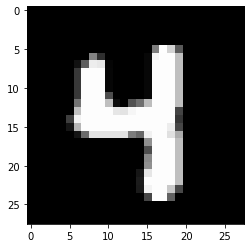

In [4]:
from scipy.signal import convolve
img_ind=58
img = mnist_data_train[img_ind][0][0,:]
plt.imshow(img, vmin=0, vmax=1,cmap="gray")

Dimension of filter:  (3, 3)


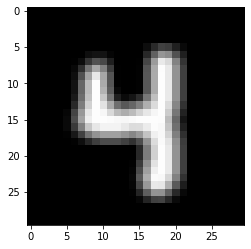

In [5]:
blur_filter = np.asarray([[1,1,1],
                          [1,1,1],
                          [1,1,1]
                          ])/9.0
print("Dimension of filter: ", blur_filter.shape)
blurry_img = convolve(img, blur_filter)
plt.imshow(blurry_img, vmin=0, vmax=1, cmap="gray")
plt.show()

To perform edge detection (here outlines of 4), we want to cancel out everything in the same area, which results in no output, in cases where the neighbor pixels are identical.

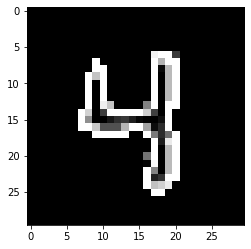

In [6]:
edge_kernel = np.asarray([[-1,-1,-1],
                          [-1,8,-1],
                          [-1,-1,-1]])
edge_img = convolve(img, edge_kernel)
plt.imshow(edge_img, vmin=0, vmax=1, cmap="gray")

The filter is maximized at the edges, since there is the largest change. Outside of the four, there is no response(black), because the high center cancel out the other around it.
The following filter is a slightly modified kernel and not as good at detecting edges.

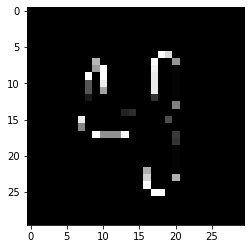

In [7]:
edge_kernel_2= np.asarray([[-1,-1,-1],
                          [-1,6,-1],
                          [-1,-1,-1]])
edge_img = convolve(img, edge_kernel_2)
plt.imshow(edge_img, vmin=0, vmax=1, cmap="gray")

## Our first CNN (Start 3.4)
In theory, we apply a convolution to a certain amount channels of an input image. and get a two dimensional image back for each convolution. Afterwards, all convolution results are stacked to one large 3D tensor.
The output has as many channels as used covolutions.
To make the covolutions nonlinear we wrap a nonlinear function around the output. To feed the output to a linear layer, we flatten the output, because the linear layer expects only a one-dimensional tensor.

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

B = 32 # Batch size.
mnist_train_loader = DataLoader(mnist_data_train, batch_size=B, shuffle=True)
mnist_test_loader = DataLoader(mnist_data_test, batch_size=B)

In [10]:
C = 1 # image is black and white and has only one channel
D = 28*28 # size of the input image (i.e. number of features)

classes = 10 # how many classes?
filters = 16 # how many filters to use?
K = 3 # size of the symmetric filter, remember we add padding to get same output size after convolution

# linear model without cnn (fully connected network)
model_linear = torch.nn.Sequential(
    torch.nn.Flatten(), # flatten the input to one d (B,C,W,H) -> (B, C*W*H) = (B, D)
    torch.nn.Linear(D, 256),
    torch.nn.Tanh(),
    torch.nn.Linear(256, classes)
)

# the filters variable defines how many kernels we run over the image, and hence how many output images (feature maps) are generated.
# each feature map is then flattened and all feature maps are concatenated to one large array.
model_cnn = torch.nn.Sequential(
    torch.nn.Conv2d(C, filters, K, padding=K//2),
    torch.nn.Tanh(),
    torch.nn.Flatten(),
    torch.nn.Linear(filters*D, classes)
)

After defining one network with only linear layers (fully connected network here) and one network which uses convolutions, we will compare both by the accuracy.

In [14]:
loss_func = torch.nn.CrossEntropyLoss()
cnn_results = train_simple_network(model_cnn, 
                                   loss_func, 
                                   mnist_train_loader, 
                                   test_loader=mnist_test_loader, 
                                   score_funcs={'Accuracy' : accuracy_score}, device=device, epochs=20)
fc_results = train_simple_network(model_linear, 
                                   loss_func, 
                                   mnist_train_loader, 
                                   test_loader=mnist_test_loader, 
                                   score_funcs={'Accuracy' : accuracy_score}, device=device, epochs=20)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

<AxesSubplot:xlabel='epoch', ylabel='test Accuracy'>

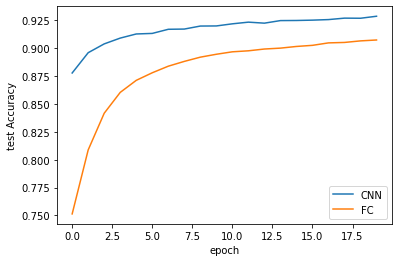

In [19]:
sns.lineplot(x = 'epoch', y="test Accuracy", data = cnn_results, label = "CNN")
sns.lineplot(x = 'epoch', y="test Accuracy", data = fc_results, label = "FC")

It can be seen that the CNN already performs better than the fully connected network after one epoch. The main reason for this is the convolution, which takes spatial dependence into account and captures it. One of the assumptions when using convolutions should always be that things located close to each other are related, and things far apart from each other aren't. This is the main advantage of convolutions and should be taken into consideration when modelling a problem.

### Pooling Layer - How to improve CNNs
One way to improve CNNs is by stacking convolutions on top of each other, seperated by nonlinear functions, or by introducing a pooling layer.

Stacking more convolutions on top of each other makes the function space which can be fitted by the network larger and hence potentially more powerful (be aware of overfitting). However, the current network is not really robust. Instead, it searches for features at specific locations on the image. This means, if a '5' is rotated by a bit or moved on the potential surface (shifting by one pixel), we might loose accuracy, since the fully connected layer at the end is expecting certain values at a given input neuron. One can work around this issue by using pooling layers. For an example, which shows the problem of shifting see book page 100. The example shows that moving each pixel by only one pixel into a certain direction can give huge differences in the probability outcomes used for the classification (31.5% to 78.2%).

In order to solve this issue, we want the property of a **translation invariant** function. This just means that shifting the input through space by a fixed amount in all directions, does not change the output. $\rightarrow$ Pooling results in greater robustness.

Pooling Layers create a partial invariance, since they only expect similiar values in the same area.
When applying pooling, we also have a symmetric kernel size K, which applies a certain function (i.e. max) at the current position. Compared to convolutions, we are not sliding the kernel by only one, but by step K. The choice of how many pixels to slide is called stride. In convolutions this is typically 1 but in pooling layers this is typically k, and hence the output (feature map) of the kernel is shrinked by a factor K. 

In pytorch, when dealing with 2D images of shape (B,C,W,H), applying a max 2D Pooling results in the shape of (B,C, W/K, H/K) since the stride is equal to the filter size by default.

*How do decide on the number of pooling layers?* 

Since each pooling layer shrinks the image by a factor K, one needs to think about appropriate sizes. For examples, a 28x28 image gets reduced to an image of 1.75x1.75 after just four round of pooling with $K=2$ $(28/2^4)=1.75$.

*Why to use pooling?*
* More robust network
* Reduction of data sizes (by a factor of K)
* Less params --> faster training

*Where to do pooling?*

If neither training time or image size is a problem, a common strategy is to increase the number of filters by K after every round of pooling, such that the number of weights roughly stays the same.

In [ ]:
model_cnn_pool = torch.nn.Sequential(
    torch.nn.Conv2d(C, filters, 3, padding=3//2),
    torch.nn.Tanh(),
    
)
# i think I stopped at 3.5.1

## Deeper Understaning of Convolutions

Before continuing I would like to understand what the convolve function does.
It (discrete convolution) is simply defined by 
$$(a*v)_n = \sum_{m = -\infty}^{\infty}a_m v_{n-m}$$
Where $N, M$ are the lengths of vector $a$ and $v$ respectively.
The above formula tells us how to geht the n-th value of the convolution, of course a generalization to multiple dimensions is also possible. When doing a full convolution, the outputs will have size (N+M-1).

Visually speaking, when doing a convolution on a one dimensional array, the second array is flipped, and then both arrays are slided across each other. The overlapping parts are multiplied and then summed.

Therfore, given two vectors $a = (1,2)'$ and $v= (0,1)'$ a convolution of the two can be constructed. We first flip $v_f = (1,0)'$ then we slide them both across each other. 
Since we do a full convolution, the resulting convolution has the size $N+M-1$

$$(a*v)_1 =\\
(a*v)_2 \\
(a*v)_3$$


 $n=(N+M-1)$ size
$$(a*v)_1 = \sum_{m = 1}^{2}a_m v_{1-m} = a_1 v_0 + a_2 v_1 = a_2 v_1 = 2\cdot 0 = 0\\
(a*v)_2 = \sum_{m = 1}^{2}a_m v_{2-m} = a_1 v_ + a_2 v_0 \\
(a*v)_3 = \sum_{m = 1}^{2}a_m v_{3-m} = a_1 v_2 + a_2 v_1 = 1*1 + 2*0$$

In [33]:
np.convolve([1, 2], [0, 1])


array([0, 1, 2])